In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import *

import lightgbm as lgb

In [102]:
#Read files 
train = pd.read_csv("../input/train.csv")
test= pd.read_csv("../input/test.csv")

model1_oof = pd.read_csv("../utility/oof_{MODEL_IDENTIFIER}.csv")
model1_test = pd.read_csv("../utility/test_{MODEL_IDENTIFIER}.csv")

model2_oof = pd.read_csv("../utility/oof_GLOVE_PREPROCSSED_1.csv")
model2_test = pd.read_csv("../utility/test_GLOVE_PREPROCSSED_1.csv")

model3_oof = pd.read_csv("../utility/oof_logreg.csv")
model3_test = pd.read_csv("../utility/test_logreg.csv")

model4_oof = pd.read_csv("../utility/oof_Fasttext_moretuning_preprocessed.csv")
model4_test = pd.read_csv("../utility/test_Fasttext_moretuning_preprocessed.csv")

model5_oof = pd.read_csv("../utility/oof_fastext_nodrop.csv")
model5_test = pd.read_csv("../utility/test_fastext_nodrop.csv")

model6_oof = pd.read_csv("../utility/oof_fastext_minimum_preproc.csv")
model6_test = pd.read_csv("../utility/test_fastext_minimum_preproc.csv")

model7_oof = pd.read_csv("../utility/oof_fastext_minimum_preproc_reg.csv")
model7_test = pd.read_csv("../utility/test_fastext_minimum_preproc_reg.csv")

print(model1_oof.columns, model2_oof.columns)

Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object') Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


In [110]:
list_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']
y = train.loc[:, list_cols].values

cvlist = list(StratifiedKFold(5, random_state=1).split(y, y[:,0]))

In [105]:
X_train = np.concatenate((model1_oof[list_cols].values,
                          model2_oof[list_cols].values,
                          model3_oof[list_cols].values,
                          model4_oof[list_cols].values,
                          model5_oof[list_cols].values,
                          model6_oof[list_cols].values,
                          model7_oof[list_cols].values,
                         ), axis=1)
X_test = np.concatenate((model1_test[list_cols].values, 
                         model2_test[list_cols].values,
                         model3_test[list_cols].values,
                         model4_test[list_cols].values,
                         model5_test[list_cols].values,
                         model6_test[list_cols].values,
                         model7_test[list_cols].values,
                        ), axis=1)

print(X_train.shape, X_test.shape)

(159571, 42) (153164, 42)


In [106]:
def predict_proba_corr(preds, target_mean):
    #preds = self.predict_proba(X)[:,1]
    d0 = target_mean
    d1 = 1 - d0
    r0 = np.mean(preds)
    r1 = 1 - r0
    gamma_0 = r0/d0
    gamma_1 = r1/d1
    return gamma_1*preds/(gamma_1*preds + gamma_0*(1 - preds))

In [107]:
for i in range(X_train.shape[1]):
    X_train[:, i] = predict_proba_corr(X_train[:, i], 0.1)
    X_test[:, i] = predict_proba_corr(X_test[:, i], 0.1)

In [ ]:
np.corrcoef()

In [ ]:
#[:, [i+6*j for j in range(7)]]

In [125]:
model = lgb.LGBMClassifier(n_estimators=1000, num_leaves=8, learning_rate=0.01, verbose=1,
                           subsample=0.7, colsample_bytree=0.7, reg_lambda=0.0,)

oof_stacked = np.zeros((len(model1_oof), len(list_cols)))
test_stacked = []
for i, col in enumerate(list_cols):
    y_tmp = y[:, i]
    #model = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_leaf=50, class_weight='balanced', n_jobs=-1)
#    model = lgb.LGBMClassifier(n_estimators=100, num_leaves=8, learning_rate=0.1, min_child_samples=500,
#                               subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0, class_weight='balanced')
#    #model = LogisticRegression(C=0.01)
    oof_stacked[:, i] = cross_val_predict(model, X_train, y_tmp, cv=cvlist, n_jobs=1, method='predict_proba', 
                                          )[:,1]
    print(oof_stacked.shape)
    #y_preds2.append(preds)
    test_stacked.append(model.fit(X_train, y_tmp).predict_proba(X_test))
    print("Score for class {} is {}".format(col, roc_auc_score(y_tmp, oof_stacked[:, i])))
print("Over auc score", roc_auc_score(y, oof_stacked))

(159571, 6)
Score for class toxic is 0.9882231348708617
(159571, 6)
Score for class severe_toxic is 0.9916798797896844
(159571, 6)
Score for class obscene is 0.9953654456514407
(159571, 6)
Score for class threat is 0.9932707710473916
(159571, 6)
Score for class insult is 0.9899053395914055
(159571, 6)
Score for class identity_hate is 0.991587621150138
Over auc score 0.9916720320168203


In [151]:
from scipy.stats import gmean, hmean
gmean1 = gmean(np.array([model1_oof[list_cols].values,
                                 model2_oof[list_cols].values,
                                 model4_oof[list_cols].values,
                                 model5_oof[list_cols].values,
                                 model6_oof[list_cols].values,
                                 model7_oof[list_cols].values,
                                ]), axis=0)
print(roc_auc_score(y, gmean1))

gmean2 = gmean(np.array([gmean1,
                                 model3_oof[list_cols].values,
                                ]), axis=0)
print(roc_auc_score(y, gmean2))

roc_auc_score(y, gmean([gmean1, gmean2], axis=0))

0.9919157724955118
0.9919844694335868


0.9921697014785181

In [99]:
oof_stacked = gmean(np.array([model1_oof[list_cols].values, 
                              model2_oof[list_cols].values,
                              model3_oof[list_cols].values,
                             model4_oof[list_cols].values,
                              model6_oof[list_cols].values,
                             ]), axis=0)
test_stacked = gmean(np.array([model1_test[list_cols].values, 
                               model2_test[list_cols].values,
                               model3_test[list_cols].values,
                               model4_test[list_cols].values,
                               model6_test[list_cols].values,
                              ]), axis=0)


In [100]:
MODEL_IDENTIFIER = "stacked_4"
oof_preds: pd.DataFrame = train[['id']]
for i, col in enumerate(list_cols):
    oof_preds.loc[:, col] = oof_stacked[:, i]

test_preds: pd.DataFrame = test[['id']]
for i, col in enumerate(list_cols):
    test_preds.loc[:, col] = test_stacked[:, i]   

oof_preds.to_csv("../utility/oof_{}.csv".format(MODEL_IDENTIFIER), index=False)
test_preds.to_csv("../utility/test_{}.csv".format(MODEL_IDENTIFIER), index=False)

/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mohsin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [63]:
gmean([test_plb[list_cols].values, test_preds[list_cols].values], axis=0)

array([[9.85980058e-01, 4.71923958e-01, 9.72496913e-01, 1.73494364e-01,
        9.34983064e-01, 5.16342181e-01],
       [4.30492381e-03, 1.00439604e-03, 1.75538739e-03, 7.42955492e-04,
        2.08850366e-03, 9.86880107e-04],
       [6.82867249e-03, 1.47147280e-03, 3.26705052e-03, 9.63247049e-04,
        2.96999773e-03, 1.81179661e-03],
       ...,
       [2.65354935e-03, 5.61014518e-04, 2.11775932e-03, 4.03977063e-04,
        1.10273836e-03, 7.38213246e-04],
       [5.55427234e-03, 8.66783624e-04, 1.57755969e-03, 8.34993382e-04,
        2.34751515e-03, 9.71989459e-03],
       [9.64330109e-01, 3.11348319e-02, 7.80260383e-01, 7.59632859e-03,
        4.84106545e-01, 1.12813272e-02]])

In [101]:
#blend with public
test_blended = test_preds.copy()
test_plb =  pd.read_csv("../utility/blend_it_all.csv")
test_blended[list_cols] = test_plb[list_cols] *0.7 + test_preds[list_cols] * 0.3

test_blended.to_csv("../utility/test_blendedv5.csv", index=False)

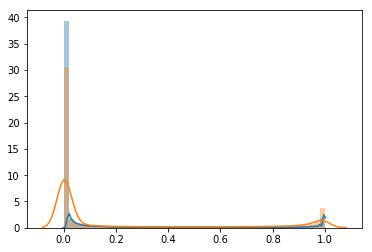

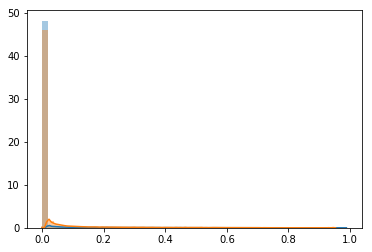

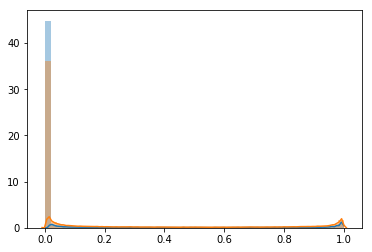

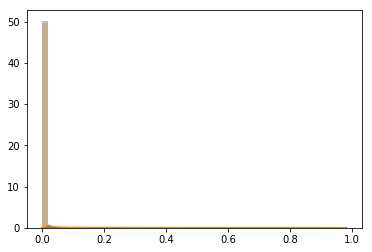

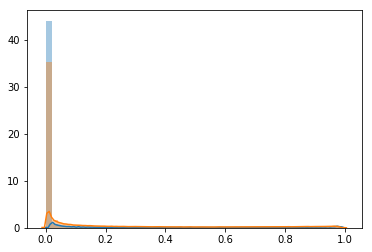

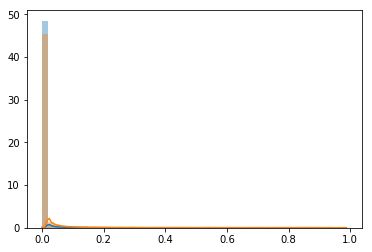

In [13]:
#Explore errors
#Let's explore toxic
#check distribution of coefs
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(6):
    sns.distplot(oof_stacked[:, i])
    sns.distplot(test_stacked[:, i])
    plt.show()

In [34]:
hateid_errs = pd.DataFrame()
hateid_errs["comment_text"]= train.comment_text.loc[np.abs(oof_stacked[:, 0] - y[:, 0]) > 0.3]
hateid_errs["preds"] = (oof_stacked[:, 0])[np.abs(oof_stacked[:, 0] - y[:, 0])  > 0.3]
hateid_errs["actual"] = (y[:, 0])[np.abs(oof_stacked[:, 0] - y[:, 0])  > 0.3]
hateid_errs["err"] = (oof_stacked[:, 0] - y[:, 0])[np.abs(oof_stacked[:, 0] - y[:, 0])  > 0.3]

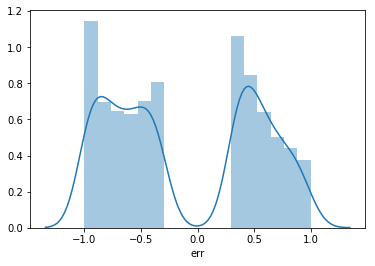

In [52]:
sns.distplot(hateid_errs["err"])
plt.show()

In [53]:
list(hateid_errs.loc[hateid_errs.err < -0.9].values)

[array(['Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...',
        0.030016476829258024, 1, -0.969983523170742], dtype=object),
 array(['"\n\nSORRY PUCK BUT NO ONE EVER SAID DICK WAS NUMBER ONE!! But he is clearly listed as being ""second only to Batman"" and a ""master detective and martial artist"" and been trained in all the mentioned combat discplines. No need to mention in skills/abilities about the battles he\'s lost and won because thats not what an encylopia is supposed to do. \n\nAlso, what your problem is your going by low end showings and not HIGH end showings where he\'s proven more than a match for a meta like Slade and pinned Shiva down in one of his earliest appearences.\n "',
        0.0161376274187

In [41]:
hateid_errs.shape

(7884, 4)

In [ ]:
#ALL CAPS WORDS - certainly a big indicator of toxic

#Replace musalman by muslim

#Replace top curse words with spaces to proper words

#Spell corrector only for curse words 

#manually correct wrong labels